In [17]:
library(tidyr)
library(dplyr)
library(corrplot)


lifeData <- read.csv("C:/Code/BIOSTAT682/Life Expectancy_v5.csv")

dim(lifeData)
head(lifeData)

[1] 1646   19

,Country,Year,Status,Life.expectancy,Adult.Mortality,Alcohol,Hepatitis.B,Measles,BMI,Polio,Total.expenditure,Diphtheria,HIV.AIDS,GDP,Population,thinness.1.19.years.,Income.composition.of.resources,Schooling,Continent
,<chr>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Afghanistan,2015,Developing,65.0,263,0.01,65,1154,19.1,6,8.16,65,0.1,0.005842592,33736494,17.2,0.479,10.1,Asia
2,Afghanistan,2014,Developing,59.9,271,0.01,62,492,18.6,58,8.18,62,0.1,0.006126965,32758200,17.5,0.476,10.0,Asia
3,Afghanistan,2013,Developing,59.9,268,0.01,64,430,18.1,62,8.13,64,0.1,0.006317450,31731688,17.7,0.470,9.9,Asia
4,Afghanistan,2012,Developing,59.5,272,0.01,67,2787,17.6,67,8.52,67,0.1,0.006699590,36969580,17.9,0.463,9.8,Asia
5,Afghanistan,2011,Developing,59.2,275,0.01,68,3013,17.2,68,7.87,68,0.1,0.006353723,29785990,18.2,0.454,9.5,Asia
6,Afghanistan,2010,Developing,58.8,279,0.01,66,1989,16.7,66,9.20,66,0.1,0.005533289,28831670,18.4,0.448,9.2,Asia


In [18]:
lifeData_train <- lifeData %>% filter(Year < 2013)
lifeData_test <- lifeData %>% filter(Year >= 2013)
dim(lifeData_train)
dim(lifeData_test)

[1] 1386   19

[1] 260  19

Warning message in apply(lifeData_train.matrix, 2, as.numeric):
"NAs introduced by coercion"


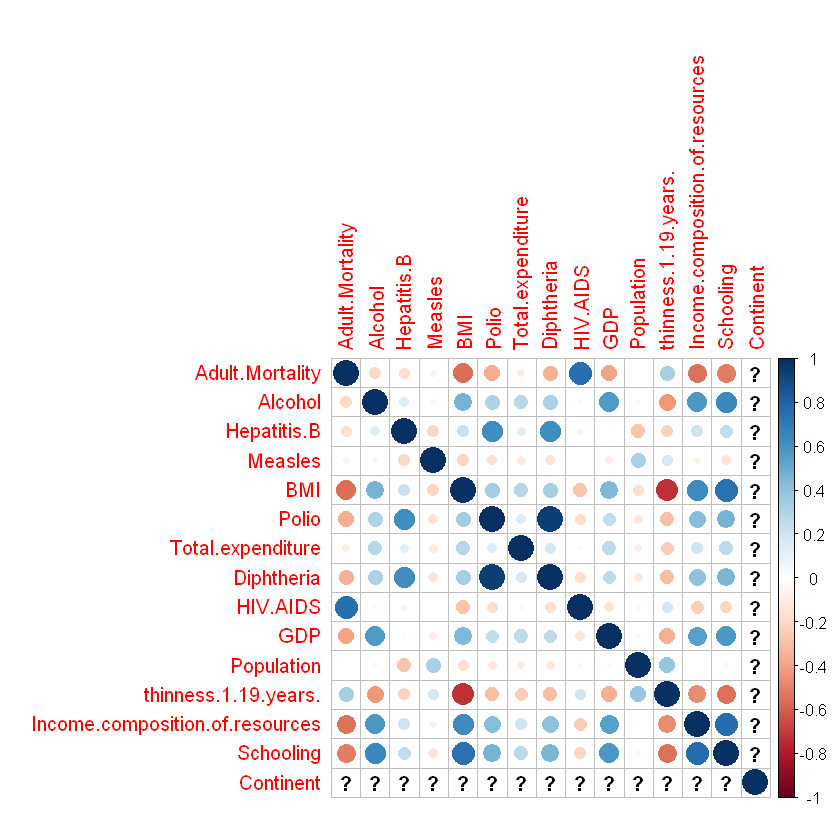

In [19]:
library(corrplot)

lifeData_train.matrix <- as.matrix(lifeData_train)[,-(1:4)]
lifeData_train.matrix <- apply(lifeData_train.matrix, 2, as.numeric)
corrplot(cor(lifeData_train.matrix))

In [20]:
library(R2jags)

status = rep(0,nrow(lifeData_train))
for (i in 1:nrow(lifeData_train)) {
  status[i] = ifelse(lifeData_train$Status[i]=="Developing",1,2)
}

continent = as.numeric(as.factor(lifeData_train$Continent))
mortality = lifeData_train$"Adult.Mortality"
infant_deaths = lifeData_train$"infant.deaths"
alcohol = lifeData_train$"Alcohol"
percExp = lifeData_train$"percentage.expenditure"
hepB = lifeData_train$"Hepatitis.B"
measles = lifeData_train$"Measles" / 100
BMI = lifeData_train$"BMI"
under5Deaths = lifeData_train$"under.five.deaths"
polio = lifeData_train$"Polio"
totalExp = lifeData_train$"Total.expenditure"
dipth = lifeData_train$"Diphtheria"
hivaids = lifeData_train$"HIV.AIDS"
gdp = lifeData_train$"GDP" 
pop = lifeData_train$"Population" / 10000000
thin1019 = lifeData_train$"thinness.1.19.years"
thin59 = lifeData_train$"thinness.5.9.years"
incomeComp = lifeData_train$"Income.composition.of.resources"
school = lifeData_train$"Schooling"
y = lifeData_train$"Life.expectancy"
N = length(lifeData_train$Country) #go through each point
J = length(unique(lifeData_train$Country)) #go through each country

# encode country
indicesDict = c(unique(lifeData_train$Country))
indices = rep(0,N)
for (i in 1:N) {
  indices[i] = which(indicesDict==lifeData_train$Country[i])
}

## Model using Country + Continent as encoding

In [21]:
X = cbind(mortality, alcohol, hepB, measles, BMI, polio,
            totalExp, dipth, hivaids, gdp, pop, thin1019, incomeComp, school)
XTX = t(X) %*% X
g = 1

save.parms.1 = c("alpha", "alphay", "beta","betay")
life_expectancy.data.1 = c("y","mortality","alcohol", 
                            "hepB","measles","BMI","polio","totalExp",
                            "dipth","hivaids","gdp","pop","thin1019",
                            "incomeComp","school","N","J","indices", "continent",
                            "g", "XTX")                         

In [22]:
life_expectancy.model.1 = function()
{
  for (i in 1:N) {
     y[i] ~ dnorm(mu[i],tau*k[i]) 
     mu[i] <- 
          alphay[indices[i]] # intercept
          + betay[continent[i],1]*mortality[i] 
          + betay[continent[i],2]*alcohol[i] 
          + betay[continent[i],3]*hepB[i] 
          + betay[continent[i],4]*measles[i] 
          + betay[continent[i],5]*BMI[i] 
          + betay[continent[i],6]*polio[i] 
          + betay[continent[i],7]*totalExp[i] 
          + betay[continent[i],8]*dipth[i] 
          + betay[continent[i],9]*hivaids[i] 
          + betay[continent[i],10]*gdp[i] 
          + betay[continent[i],11]*pop[i] 
          + betay[continent[i],12]*thin1019[i] 
          + betay[continent[i],13]*incomeComp[i] 
          + betay[continent[i],14]*school[i] 
    k[i] ~ dgamma(3/2,3/2)
  }
  alpha ~ dnorm(60, 1e-4)
  for (j in 1:J) {
    alphay[j] ~ dnorm(alpha, tau2)
  }      

  for (k in 1:14) {
    beta[k] ~ dnorm(0,1e-6)
  }
  
  for(j in 1:6) {
      betay[j,1:14] ~ dmnorm(beta, XTX*tau2/g) 
  }
  tau ~ dgamma(1e-6,1e-6)
  tau2 ~ dgamma(1e-6,1e-6)
}

In [23]:
life_expectancy.out.1 = jags(data=life_expectancy.data.1,parameters.to.save=save.parms.1,model.file=life_expectancy.model.1,
                           n.chains=3,n.iter=20000,n.burnin=5000,n.thin=1)
print(life_expectancy.out.1, digits = 6)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1386
   Unobserved stochastic nodes: 1540
   Total graph size: 37961

Initializing model

Inference for Bugs model at "C:/Users/MINGCH~1/AppData/Local/Temp/Rtmp0sJ9BN/model15041f1336a9.txt", fit using jags,
 3 chains, each with 20000 iterations (first 5000 discarded)
 n.sims = 45000 iterations saved
                mu.vect   sd.vect        2.5%         25%         50%
alpha         67.399154  0.487182   66.478210   67.054065   67.391173
alphay[1]     64.423000  0.602197   63.235011   64.016041   64.426622
alphay[2]     68.846414  0.983217   65.251728   68.625899   69.017892
alphay[3]     68.938338  0.478400   68.051249   68.595713   68.927259
alphay[4]     58.010765  0.559545   56.922191   57.623550   58.011516
alphay[5]     67.820857  0.515539   66.851351   67.459422   67.802779
alphay[6]     68.948564  0.429332   68.133098   68.650384   68.942304
alphay[7]     

In [24]:
attach.jags(life_expectancy.out.1)

# alphay.1 <- mcmc(alphay)
# alphay.1 <- apply(alphay.1, 2, mean)
# betay.1 <- mcmc(betay)
# betay.1 <- apply(betay.1, 2, mean)
# gamma.1 <- mcmc(gamma)
# gamma.1 <- apply(gamma.1, 2, mean)

In [25]:
alphay.1 <- apply(mcmc(alphay),2,mean)
head(alphay.1)

var1     var2     var3     var4     var5     var6 
64.42300 68.84641 68.93834 58.01077 67.82086 68.94856

In [26]:
betay_matrix <- apply(mcmc(betay), 2:3, mean)

In [27]:

X = cbind(mortality, alcohol, hepB, measles, BMI, polio,
            totalExp, dipth, hivaids, gdp, pop, thin1019, incomeComp, school)

fit = rep(NA, nrow(lifeData_train))
for (i in 1:nrow(lifeData_train)) {
    fit[i] = alphay.1[indices[i]]
    continent_id = which(lifeData_train[i,]$Continent == levels(as.factor(lifeData_train$Continent)))
    for (j in 1:14) {
        fit[i] = fit[i] + betay_matrix[continent_id, j] * X[i,j]
    }
}


In [28]:
r = fit - lifeData_train[,4]

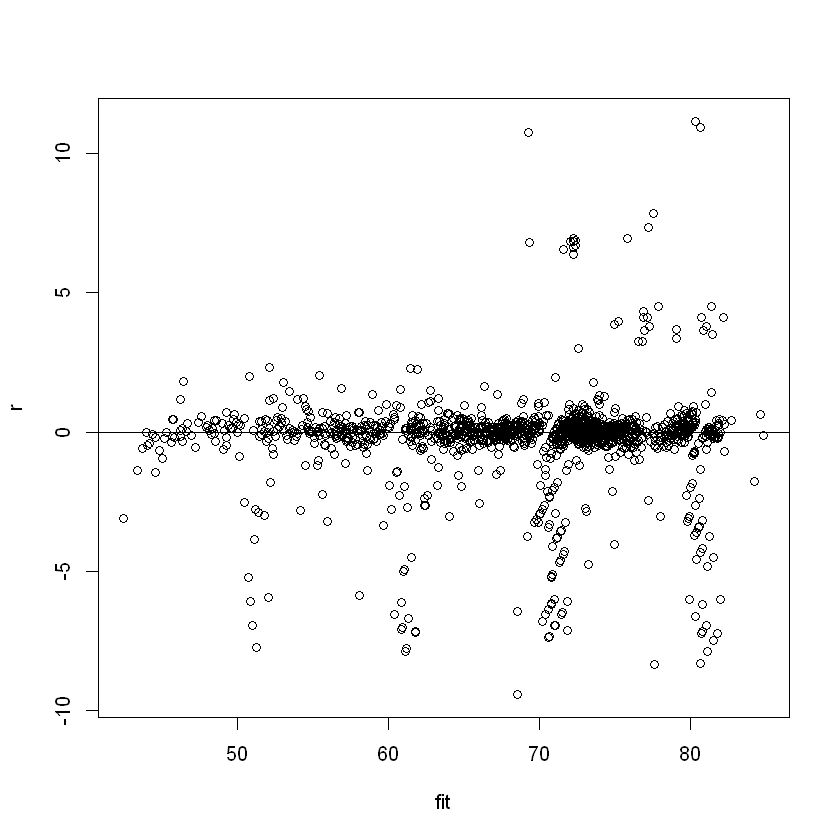

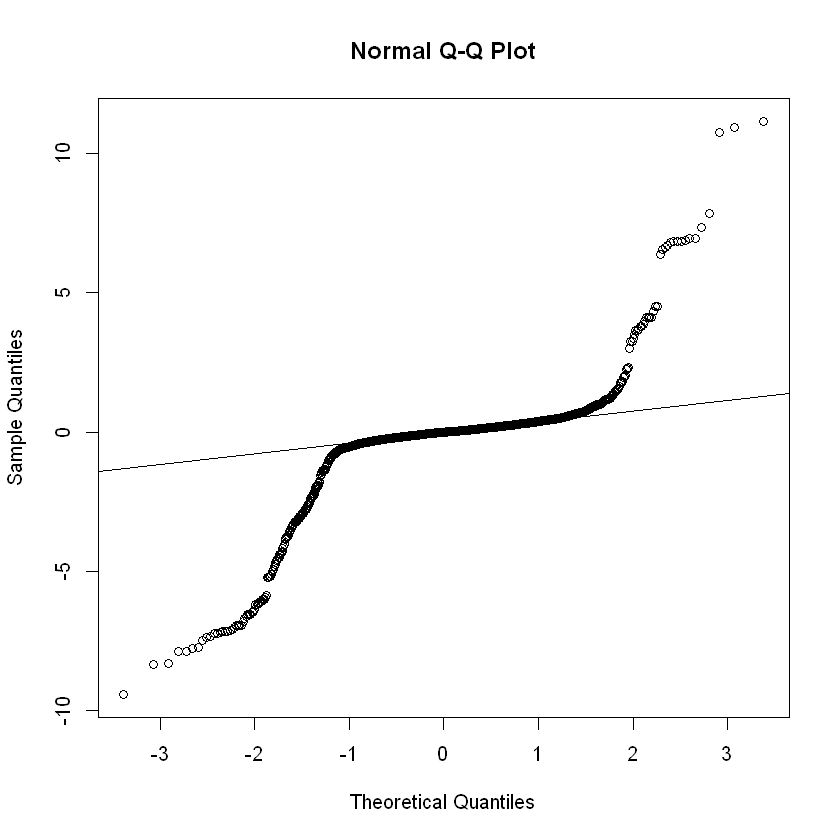

In [29]:
plot(fit, r)
abline(h =0)
qqnorm(r)
qqline(r)

# Test

In [30]:
status_test = rep(0,nrow(lifeData_test))
for (i in 1:nrow(lifeData_test)) {
  status_test[i] = ifelse(lifeData_test$Status[i]=="Developing",0,1)
}
mortality_test = lifeData_test$"Adult.Mortality"
alcohol_test = lifeData_test$"Alcohol"
hepB_test = lifeData_test$"Hepatitis.B"
measles_test = lifeData_test$"Measles" / 100
BMI_test = lifeData_test$"BMI"
polio_test = lifeData_test$"Polio"
totalExp_test = lifeData_test$"Total.expenditure"
dipth_test = lifeData_test$"Diphtheria"
hivaids_test = lifeData_test$"HIV.AIDS"
gdp_test = lifeData_test$"GDP"
pop_test = lifeData_test$"Population" / 10000000
thin1019_test = lifeData_test$"thinness.1.19.years"
incomeComp_test = lifeData_test$"Income.composition.of.resources"
school_test = lifeData_test$"Schooling"

indicesDict_test = c(unique(lifeData_test$Country))
indices_test = rep(0,nrow(lifeData_test))
for (i in 1:nrow(lifeData_test)) {
  indices_test[i] = which(indicesDict==lifeData_test$Country[i])
}

In [31]:
X_test = cbind(mortality_test, alcohol_test, hepB_test, measles_test, BMI_test, polio_test,
            totalExp_test, dipth_test, hivaids_test, gdp_test, pop_test, thin1019_test, incomeComp_test, school_test)

fit_test = rep(NA, nrow(lifeData_test))
for (i in 1:nrow(lifeData_test)) {
    fit_test[i] = alphay.1[indices_test[i]]
    continent_id = which(lifeData_test[i,]$Continent == levels(as.factor(lifeData_test$Continent)))
    for (j in 1:14) {
        fit_test[i] = fit_test[i] + betay_matrix[continent_id, j] * X_test[i,j]
    }
}

In [32]:
rmse <- function(x,y) {
    return(sqrt(mean((x-y)^2)))
}
rmse(fit_test, lifeData_test[,4])

[1] 2.579603